In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline


medicare = pd.read_csv("/Users/saifbhatti/Desktop/Northwestern/sy1920/w20/iems308/iems308-saifbhatti/sub_il_medicare.csv")
medicare= pd.DataFrame(medicare) #create dataframe
list(medicare) #list all the columns in the dataset

['National Provider Identifier',
 'Last Name/Organization Name of the Provider',
 'First Name of the Provider',
 'Middle Initial of the Provider',
 'Credentials of the Provider',
 'Gender of the Provider',
 'Entity Type of the Provider',
 'Street Address 1 of the Provider',
 'Street Address 2 of the Provider',
 'City of the Provider',
 'Zip Code of the Provider',
 'State Code of the Provider',
 'Country Code of the Provider',
 'Provider Type',
 'Medicare Participation Indicator',
 'Place of Service',
 'HCPCS Code',
 'HCPCS Description',
 'HCPCS Drug Indicator',
 'Number of Services',
 'Number of Medicare Beneficiaries',
 'Number of Distinct Medicare Beneficiary/Per Day Services',
 'Average Medicare Allowed Amount',
 'Average Submitted Charge Amount',
 'Average Medicare Payment Amount',
 'Average Medicare Standardized Amount']

In [2]:
#Subset to Illinois Data
IL_med = medicare[(medicare['State Code of the Provider']=='IL')] 
IL_med.shape[0] #returns >20000 data points across IL

21571

In [3]:
#Subset data to only relevant info
IL_med = IL_med[['Zip Code of the Provider','Average Medicare Payment Amount','Number of Services']]
IL_med.head()

,Zip Code of the Provider,Average Medicare Payment Amount,Number of Services
0,602011718,22.700525,438.0
1,602011718,21.189583,24.0
2,606573014,5.060220,182.0
3,606573014,7.140000,17.0
4,606573014,55.513774,53.0


In [4]:
#Create new column with 3 digit zip code
IL_med['3dzip'] = IL_med['Zip Code of the Provider'].astype(str).str[0:3]
IL_med = IL_med.drop(['Zip Code of the Provider'],axis=1)
IL_med.head()

,Average Medicare Payment Amount,Number of Services,3dzip
0,22.700525,438.0,602
1,21.189583,24.0,602
2,5.060220,182.0,606
3,7.140000,17.0,606
4,55.513774,53.0,606


In [5]:
IL_med = pd.get_dummies(data=IL_med,columns=['3dzip']) #one-hot encoding
# list(IL_med)

In [6]:
#remove outliers in the data
IL_med_std = IL_med[np.abs(IL_med['Average Medicare Payment Amount']) - (IL_med['Average Medicare Payment Amount'].mean()) <= (3*IL_med['Average Medicare Payment Amount'].std())]
IL_med_std = IL_med_std.reset_index(drop=True)

IL_med_std = IL_med[np.abs(IL_med['Number of Services']) - (IL_med['Number of Services'].mean()) <= (3*IL_med['Number of Services'].std())]
IL_med_std = IL_med_std.reset_index(drop=True)

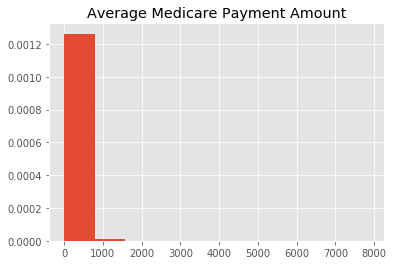

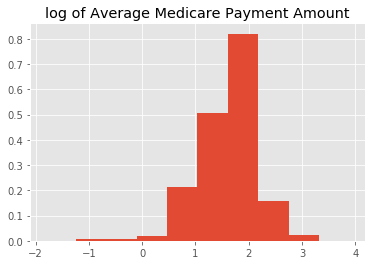

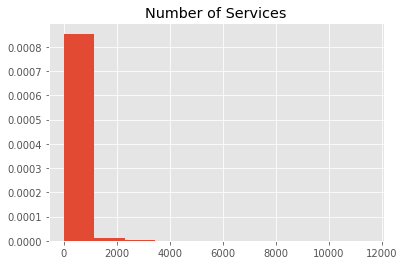

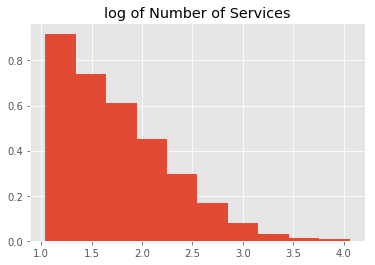

In [7]:
#normalise features
plt.hist(x=IL_med_std['Average Medicare Payment Amount'],normed=1)
plt.title('Average Medicare Payment Amount')
plt.show()
IL_med_std['Average Medicare Payment Amount'] = np.log10(IL_med_std['Average Medicare Payment Amount'])
plt.hist(x=IL_med_std['Average Medicare Payment Amount'],normed=1)
plt.title('log of Average Medicare Payment Amount')
plt.show()

plt.hist(x=IL_med_std['Number of Services'],normed=1)
plt.title('Number of Services')
plt.show()
IL_med_std['Number of Services'] = np.log10(IL_med_std['Number of Services'])
plt.hist(x=IL_med_std['Number of Services'],normed=1)
plt.title('log of Number of Services')
plt.show()

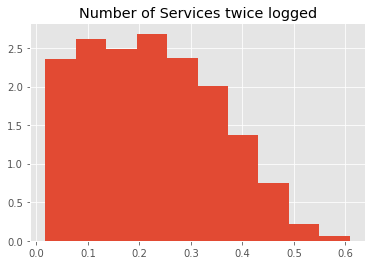

In [8]:
#Number of Services still not normal; log once more
IL_med_std['Number of Services'] = np.log10(IL_med_std['Number of Services'])
plt.hist(x=IL_med_std['Number of Services'],normed=1)
plt.title('Number of Services twice logged')
plt.show()

In [9]:
#Standardise dataset
avg_medstd_max = np.min(IL_med_std['Average Medicare Payment Amount'])
avg_medstd_min = np.max(IL_med_std['Average Medicare Payment Amount'])
services_min = np.min(IL_med_std['Number of Services'])
services_max = np.max(IL_med_std['Number of Services'])

IL_med_std['Average Medicare Payment Amount'] = (IL_med_std['Average Medicare Payment Amount'] - avg_medstd_min) / avg_medstd_max
IL_med_std['Number of Services'] = (IL_med_std['Number of Services'] - services_min) / services_max


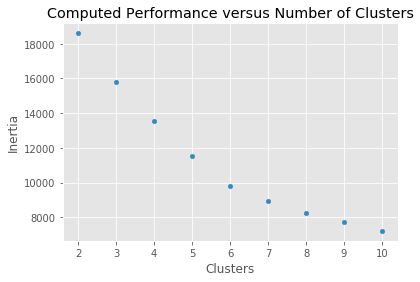

In [10]:
cluster_qual = pd.DataFrame(columns = ['Inertia', 'Clusters'])
for i in range(2,11):
    kmeans = KMeans(n_clusters = i)
    kmeans = kmeans.fit(IL_med_std)
    cluster_qual.loc[i-2] = [kmeans.inertia_,i]

cluster_qual.plot.scatter(x='Clusters',y='Inertia',title='Computed Performance versus Number of Clusters')

#Based on the graph, cluster =6
kmeans = KMeans(n_clusters = 6)
kmeans = kmeans.fit(IL_med_std)
labels = kmeans.predict(IL_med_std)
centroids = kmeans.cluster_centers_

In [11]:
maxClusters = 10
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(IL_med_std)
    silhouette_avg = silhouette_score(IL_med_std, kmeans.labels_)
    silh.append(silhouette_avg)

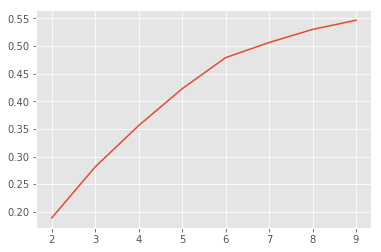

In [12]:
plt.plot(range(2,maxClusters),silh)
plt.plot(xlab="Number of Clusters",ylab="silhouette score",title="Silohuette scores")
plt.show()

In [21]:
#Compute silhouette scores
df_with_labels = IL_med_std.copy()
df_with_labels['labels'] = labels
sampled_data = df_with_labels.sample(n=10000)
silhouette_avg = silhouette_score(sampled_data.drop('labels',axis=1),sampled_data['labels'])
print('The average silhouette score is ' + str(silhouette_avg))

#Add cluster column to IL_med_std
IL_med_std['cluster'] = labels

The average silhouette score is 0.566746850195


In [14]:
IL_med_std['cluster'].value_counts() #examine cluster spread

4    7500
3    4049
1    3107
2    2501
5    2319
0    2063
Name: cluster, dtype: int64

In [15]:
IL_med_std.groupby('cluster').mean()

,Average Medicare Payment Amount,Number of Services,3dzip_472,3dzip_512,3dzip_600,3dzip_601,3dzip_602,3dzip_603,3dzip_604,3dzip_605,...,3dzip_623,3dzip_624,3dzip_625,3dzip_626,3dzip_627,3dzip_628,3dzip_629,3dzip_660,3dzip_681,3dzip_837
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.269061,0.330670,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
1,1.240264,0.350072,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
2,1.241469,0.349307,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
3,1.234759,0.324831,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
4,1.278514,0.338795,0.000533,0.000133,0.0,0.0,0.047333,0.018533,0.0,0.0,...,0.021333,0.017333,0.036133,0.008,0.1224,0.0356,0.042933,0.000133,0.000133,0.0004
5,1.247729,0.353441,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000


In [16]:
#Let the sanity checks begin
fiscal = IL_med_std[['cluster','Average Medicare Payment Amount','Number of Services']].copy()
fiscal['fiscal_indicator'] = fiscal['Average Medicare Payment Amount'] * fiscal['Number of Services'] 

In [17]:
sum_cluster0 = fiscal.loc[fiscal['cluster']==0,'fiscal_indicator']
sum_cluster1 = fiscal.loc[fiscal['cluster']==1,'fiscal_indicator']
sum_cluster2 = fiscal.loc[fiscal['cluster']==2,'fiscal_indicator']
sum_cluster3 = fiscal.loc[fiscal['cluster']==3,'fiscal_indicator']
sum_cluster4 = fiscal.loc[fiscal['cluster']==4,'fiscal_indicator']
sum_cluster5 = fiscal.loc[fiscal['cluster']==5,'fiscal_indicator']
fiscal.groupby('cluster').mean()

,Average Medicare Payment Amount,Number of Services,fiscal_indicator
cluster,,,
0,1.269061,0.330670,0.427260
1,1.240264,0.350072,0.444372
2,1.241469,0.349307,0.442539
3,1.234759,0.324831,0.410333
4,1.278514,0.338795,0.443981
5,1.247729,0.353441,0.451399


In [18]:
IL_med_std.groupby('cluster').mean()

,Average Medicare Payment Amount,Number of Services,3dzip_472,3dzip_512,3dzip_600,3dzip_601,3dzip_602,3dzip_603,3dzip_604,3dzip_605,...,3dzip_623,3dzip_624,3dzip_625,3dzip_626,3dzip_627,3dzip_628,3dzip_629,3dzip_660,3dzip_681,3dzip_837
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.269061,0.330670,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
1,1.240264,0.350072,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
2,1.241469,0.349307,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
3,1.234759,0.324831,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
4,1.278514,0.338795,0.000533,0.000133,0.0,0.0,0.047333,0.018533,0.0,0.0,...,0.021333,0.017333,0.036133,0.008,0.1224,0.0356,0.042933,0.000133,0.000133,0.0004
5,1.247729,0.353441,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000


In [19]:
std_fiscal_cl0 = sum_cluster0 / (IL_med_std['cluster']==0).sum()
std_fiscal_cl1 = sum_cluster1 / (IL_med_std['cluster']==1).sum()
std_fiscal_cl2 = sum_cluster2 / (IL_med_std['cluster']==2).sum()
std_fiscal_cl3 = sum_cluster3 / (IL_med_std['cluster']==3).sum()
std_fiscal_cl4 = sum_cluster4 / (IL_med_std['cluster']==4).sum()
std_fiscal_cl5 = sum_cluster5 / (IL_med_std['cluster']==5).sum()


In [22]:
fiscal.groupby('cluster').mean()

,Average Medicare Payment Amount,Number of Services,fiscal_indicator
cluster,,,
0,1.269061,0.330670,0.427260
1,1.240264,0.350072,0.444372
2,1.241469,0.349307,0.442539
3,1.234759,0.324831,0.410333
4,1.278514,0.338795,0.443981
5,1.247729,0.353441,0.451399


In [26]:
IL_med_std[IL_med_std['cluster']==5].mean()

Average Medicare Payment Amount    1.247729
Number of Services                 0.353441
3dzip_472                          0.000000
3dzip_512                          0.000000
3dzip_600                          0.000000
3dzip_601                          0.000000
3dzip_602                          0.000000
3dzip_603                          0.000000
3dzip_604                          1.000000
3dzip_605                          0.000000
3dzip_606                          0.000000
3dzip_607                          0.000000
3dzip_608                          0.000000
3dzip_609                          0.000000
3dzip_610                          0.000000
3dzip_611                          0.000000
3dzip_612                          0.000000
3dzip_613                          0.000000
3dzip_614                          0.000000
3dzip_615                          0.000000
3dzip_616                          0.000000
3dzip_617                          0.000000
3dzip_618                       